# Example: Comparing different compression methods for temperature (`t`) and specific humidity (`q`)

> [!NOTE]
> The online laboratory has only been tested in recent Firefox and Chrome browsers. Some features may not (yet) be supported in Safari browsers.

> [!CAUTION]
> Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

## Setting up the online laboratory

First, we import several utility packages to setup this notebook for data compression in climate science and meteorology.

Please refer back to the [01-intro.ipynb](../01-intro.ipynb) notebook for a deeper explanation.

In [1]:
import sys
sys.path.insert(0, "..")

from pathlib import Path

import dask
import fcbench
import numpy as np
import pandas as pd
import xarray as xr

[pyodide]: Loading xarray, pandas, tzdata, field-compression-benchmark, cfgrib, attrs, click, eccodes, cffi, pycparser, findlibs, dask, cloudpickle, importlib_metadata, zipp, Jinja2, MarkupSafe, partd, locket, toolz, pyyaml, netcdf4, cftime, h5py, pkgconfig, numcodecs, msgpack, pint, typing-extensions, xeofs, pooch, lzma, platformdirs, scikit-learn, scipy, openblas, joblib, distutils, threadpoolctl, statsmodels, patsy, tqdm, xarray-datatree, zarr, asciitree, xhistogram
[pyodide]: Loaded Jinja2, MarkupSafe, asciitree, attrs, cffi, cfgrib, cftime, click, cloudpickle, dask, distutils, eccodes, field-compression-benchmark, findlibs, h5py, importlib_metadata, joblib, locket, lzma, msgpack, netcdf4, numcodecs, openblas, pandas, partd, patsy, pint, pkgconfig, platformdirs, pooch, pycparser, pyyaml, scikit-learn, scipy, statsmodels, threadpoolctl, toolz, tqdm, typing-extensions, tzdata, xarray, xarray-datatree, xeofs, xhistogram, zarr, zipp
[pyodide]: Memory usage has grown to 176.9MiB (from 4

In [2]:
import utils


fcbench.codecs.preload()

dask.config.set(array__chunk_size="4MiB");

[pyodide]: Loading sympy, mpmath, ipyfilite, ipywidgets, widgetsnbextension, jupyterlab_widgets, kerchunk, fsspec, ujson
[pyodide]: Loaded fsspec, ipyfilite, ipywidgets, jupyterlab_widgets, kerchunk, mpmath, sympy, ujson, widgetsnbextension
Loaded the fcbench.codecs.Asinh codec ...
Loaded the fcbench.codecs.BitRound codec ...
Loaded the fcbench.codecs.FixedOffsetScale codec ...
Loaded the fcbench.codecs.Identity codec ...
Loaded the fcbench.codecs.LinearQuantize codec ...
Loaded the fcbench.codecs.Log codec ...
Loaded the fcbench.codecs.RandomProjection codec ...
Loaded the fcbench.codecs.Reinterpret codec ...
Loaded the fcbench.codecs.Round codec ...
Loaded the fcbench.codecs.SwizzleReshape codec ...
Loaded the fcbench.codecs.Sz3 codec ...
Loaded the fcbench.codecs.UniformNoise codec ...
Loaded the fcbench.codecs.Zfp codec ...
Loaded the fcbench.codecs.Zlib codec ...
Loaded the fcbench.codecs.Zstd codec ...
[pyodide]: Memory usage has grown to 254.8MiB (from 176.9MiB) for this noteboo

## Retrieving and loading the dataset

First, we look at temperature and specific humidity (the percentage of the air weight that water contributes) from the global ensemble forecast dataset TIGGE, which we retrieve with the following MARS request:

```
retrieve,
dataset=tigge,
date=2024-08-02,
expver=prod,
grid=2/2,
levtype=pl,
levelist=1000,
model=glob,
origin=ecmwf,
param=130/133,
step=240,
time=00:00:00,
type=fc,
format=netcdf,
target="tigge_pl_t_q_dx=2_2024_08_02.nc"
```

The pressure level of 100hPa corresponds to an elevation of roughly 111 metres above sealevel.

In [3]:
data_path = Path("data") / "01-t-q.nc"

### Option 1: Retrieve the dataset using the `ecmwfapi`

If you have an API key from https://api.ecmwf.int/v1/key/, you can use the `ecmwfapi` to download the dataset directly from MARS by uncommenting the following code:

In [4]:
from ecmwfapi import ECMWFDataServer

if False:  # toggle to use the ecmwfapi
    server = ECMWFDataServer(**{
        "url"   : "<ECMWF-API-URL>",
        "key"   : "<ECMWF-API-KEY>",
        "email" : "<ECMWF-API-EMAIL>"
    })
    
    server.retrieve(
        {
            "dataset": "tigge",
            "date": "2024-08-02",
            "expver": "prod",
            "grid": "2/2",
            "levtype": "pl",
            "levelist": "1000",
            "model": "glob",
            "origin": "ecmwf",
            "param": "130/133",
            "step": "240",
            "time": "00:00:00",
            "type": "fc",
            "format" : "netcdf",
            "target": str(data_path),
        }
    )

[pyodide]: Loading ecmwf-api-client
[pyodide]: Loaded ecmwf-api-client


### Option 2: Download this dataset from an S3 bucket

If you cannot access the dataset with the `ecmwfapi`, you can also download it from <https://a3s.fi/compression.lab.climet.eu/tigge_pl_t_q_dx=2_2024_08_02.nc>:

In [5]:
import shutil
from urllib.request import urlopen

download_url = "https://a3s.fi/compression.lab.climet.eu/tigge_pl_t_q_dx=2_2024_08_02.nc"

if True:  # toggle to use the ecmwfapi
    with urlopen(download_url) as response:
        with data_path.open("wb") as file:
            shutil.copyfileobj(response, file)

### Options 1 & 2: Open the dataset using `xarray`

In [6]:
ds = utils.open_dataset(data_path)
ds

<xarray.Dataset>
Dimensions:    (longitude: 180, latitude: 91, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * time       (time) datetime64[ns] 2024-08-12
Data variables:
    t          (time, latitude, longitude) float32 dask.array<chunksize=(1, 91, 180), meta=np.ndarray>
    q          (time, latitude, longitude) float32 dask.array<chunksize=(1, 91, 180), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-27 11:51:26 GMT by grib_to_netcdf-2.35.3: /opt/ecmw...
    path:         data/01-t-q.nc

## Plot the loaded dataset

In [7]:
import earthkit
import earthkit.plots.quickmap

[pyodide]: Loading earthkit, earthkit-data, Cartopy, shapely, pyshp, pyproj, geos, cdsapi, cads-api-client, multiurl, setuptools, earthkit-geo, earthkit-meteo, ecmwf-opendata, entrypoints, filelock, geopandas, fiona, cligj, jsonschema, pyrsistent, lru-dict, markdown, pdbufr, earthkit-plots, adjustText, earthkit-plots-default-styles, earthkit-regrid, earthkit-transforms, rasterio, affine, gdal, click-plugins
[pyodide]: Loaded Cartopy, adjustText, affine, cads-api-client, cdsapi, click-plugins, cligj, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-transforms, ecmwf-opendata, entrypoints, filelock, fiona, gdal, geopandas, geos, jsonschema, lru-dict, markdown, multiurl, pdbufr, pyproj, pyrsistent, pyshp, rasterio, setuptools, shapely


/lib/python3.11/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


[pyodide]: Memory usage has grown to 305.8MiB (from 254.8MiB) for this notebook


We first plot the loaded dataset. `earthkit` provides the
```python
earthkit.plots.quickmap.plot(
    data, units=None, style=None, **kwargs,
) -> earthkit.plots.components.maps.Map
```
helper function to plot weather and climate maps data, which we utilize in our `plot_data` function.

In [8]:
import numpy as np

def auto_range(data, divergence_point=None, n_levels=earthkit.plots.schemas.schema.default_style_levels):
    try:
        data = data.to_numpy()
    except AttributeError:
        pass
    
    min_value = np.nanmin(data)
    max_value = np.nanmax(data)

    if divergence_point is not None:
        max_diff = max(max_value - divergence_point, divergence_point - min_value)
        max_value = max_diff
        min_value = -max_diff

    data_range = max_value - min_value

    initial_bin = data_range / n_levels

    magnitude = 10 ** (np.floor(np.log10(initial_bin)))
    bin_width = initial_bin - (initial_bin % -magnitude)

    min_value -= min_value % bin_width
    max_value -= max_value % -bin_width

    if divergence_point is not None:
        min_value += divergence_point
        max_value += divergence_point

    return np.linspace(
        min_value,
        max_value,
        n_levels + 1,
    ).tolist()
earthkit.plots.styles.levels.auto_range = auto_range

In [9]:
def xarray_source_datetime(self):
    datetimes = [pd.to_datetime(dt).to_pydatetime() for dt in np.atleast_1d(self.data.time.values)]
    return {
        "base_time": datetimes,
        "valid_time": datetimes,
    }
earthkit.plots.sources.XarraySource.datetime = xarray_source_datetime

In [10]:
def format_units(units, exponential_notation=False):
    units = earthkit.plots.metadata.units._pintify(units)
    if units.dimensionless:
        return "dimensionless"
    latex_str = f"{units:~L}"
    if exponential_notation:
        raise NotImplementedError("Exponential notation is not yet supported.")
    return f"${latex_str}$"
earthkit.plots.metadata.units.format_units = format_units

In [11]:
def xarray_source_x_values(self):
    super(earthkit.plots.sources.XarraySource, self).x_values
    return self.data[self._x].values
setattr(earthkit.plots.sources.XarraySource, "x_values", property(xarray_source_x_values))

In [12]:
import copy

def plot_data(data: dict, title_prefix="", title_postfix="", error=False):
    UNITS = dict(t="degC")
    DIVERGENCE_POINT = dict(t=0.0)
    
    for name, data in data.items():
        units = None if error else UNITS.get(name, None)
        divergence_point = 0.0 if error else DIVERGENCE_POINT.get(name, None)

        source = earthkit.plots.sources.XarraySource(data)

        # compute the default style that earthkit.maps would apply
        style = copy.deepcopy(earthkit.plots.styles.auto.guess_style(
            source, units=units or source.units,
        ))
        
        # modify the style levels to get a smoother colourbar
        style._levels = earthkit.plots.styles.levels.Levels(
            earthkit.plots.styles.levels.auto_range(
                style.convert_units(data.values, source.units),
                divergence_point=divergence_point, n_levels=256,
            )
        )
        style._legend_kwargs["ticks"] = earthkit.plots.styles.levels.auto_range(
            style.convert_units(data.values, source.units),
            divergence_point=divergence_point, n_levels=10,
        )

        # force the colourmap to coolwarm for error plots
        style._colors = "coolwarm" if error else style._colors

        # quickplot with the modified style
        chart = earthkit.plots.quickmap.plot(
            data, units=units, style=style,
        )

        chart.title(
            f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
        )

        chart.show()

/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


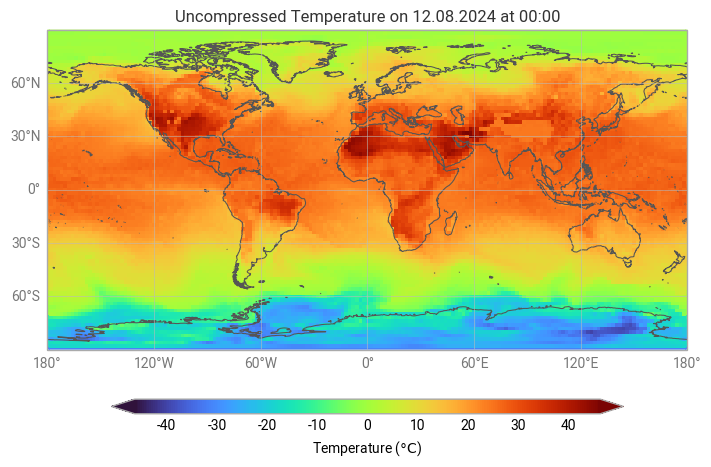

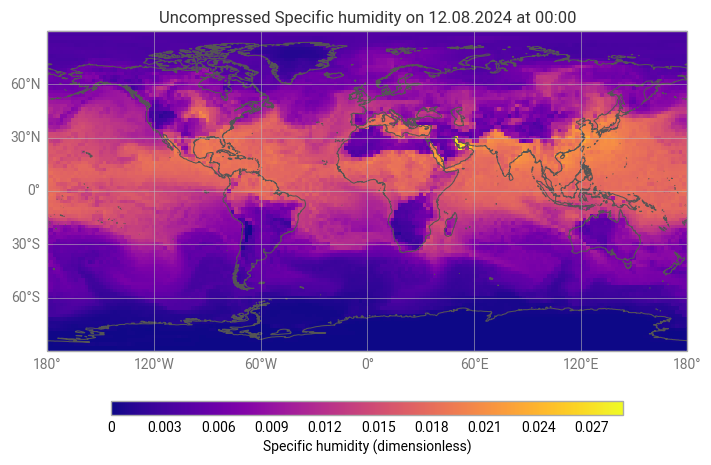

In [13]:
plot_data(ds, title_prefix="Uncompressed ")

## Comparing several different compression methods

### Run a Linear Quantization compressor

One of the codecs included in `fcbench.codecs` is the lossy `LinearQuantize` codec that rescales real-valued data from $[min; max]$ to the integer range $[0; 2^b - 1]$. Here, $b$ is the number of bit precision you want to keep. The compressor outputs an array of values of the smallest unsigned integer type that can represent values of $b$ bits, e.g. `u8`, `u16`, `u32`, or `u64`. If $b$ is not one of these powers of two, a lossless integer compressor can be added to further compress the data.

After you have finished using a compressor, it is important to overwrite or delete it to allow its resources to be reused.

In [14]:
ds_linquant = {}
stats_linquant = {}

for name, da in ds.items():
    linquant_compressor = [
        fcbench.codecs.LinearQuantize(bits=4, dtype=str(da.dtype)),
        fcbench.codecs.Zlib(level=4),
    ]
    
    ds_linquant[name], stats_linquant[name] = (
        fcbench.compressor.compute_dataarray_compress_decompress(
            da, linquant_compressor,
        )
    )
    print(f"{da.long_name}" + ":")
    display(utils.format_compress_stats(linquant_compressor, stats_linquant[name]))
    
linquant_compressor = str(linquant_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"LinearQuantize(dtype='f32', bits=4)",4.00,0.03,0.11,8.2,3.5
Zlib(level=4),6.44,0.01,0.02,28.0,6.6


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"LinearQuantize(dtype='f32', bits=4)",4.00,0.06,0.13,8.2,3.5
Zlib(level=4),5.05,0.01,0.02,32.1,7.5


When we plot the compressed data, we can see that it has indeed been quantized to $2^4 = 16$ values (per data chunk).

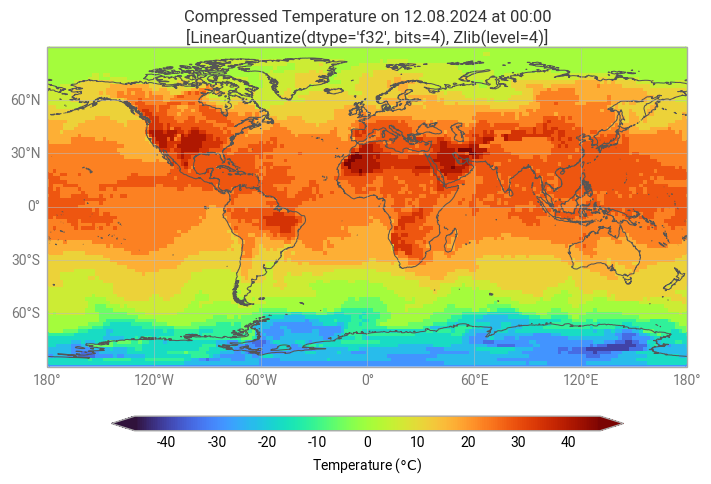

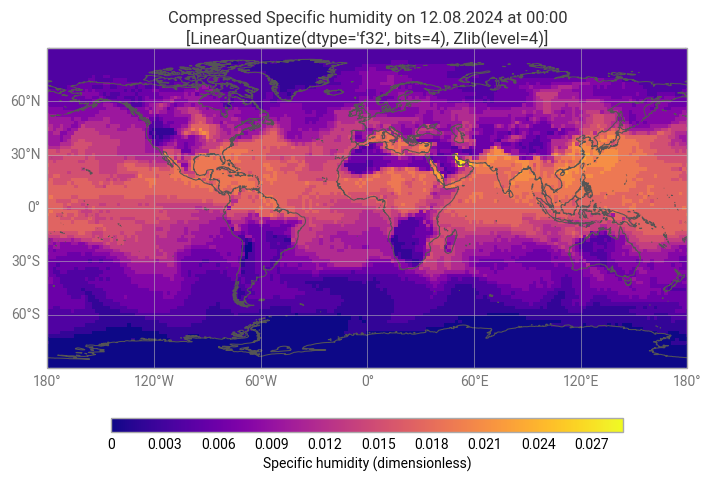

[pyodide]: Memory usage has grown to 366.9MiB (from 305.8MiB) for this notebook


In [15]:
plot_data(
    ds_linquant, title_prefix="Compressed ",
    title_postfix=f"\n{linquant_compressor}",
)

## Plot the Linear Quantization compression error

The following is a helper function to compute the different relative errors.

In [16]:
def compute_relative_errors(da_compressed, da):
    da_error = da_compressed - da

    norm_L1_error = np.abs(da_error).sum().values
    norm_L2_error = np.sqrt((da_error**2).sum().values)
    norm_Linf_error = np.abs(da_error).max().values

    norm_L1_original = np.abs(da).sum().values
    norm_L2_original = np.sqrt((da**2).sum().values)
    norm_Linf_original = np.abs(da).max().values

    relative_error_L1 = norm_L1_error / norm_L1_original
    relative_error_L2 = norm_L2_error / norm_L2_original
    relative_error_Linf = norm_Linf_error / norm_Linf_original

    return {
        "Relative_Error_L1": relative_error_L1,
        "Relative_Error_L2": relative_error_L2,
        "Relative_Error_Linf": relative_error_Linf,
    }

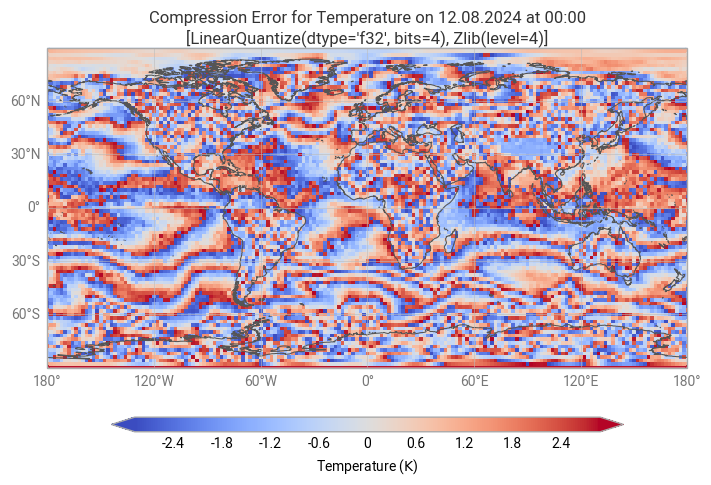

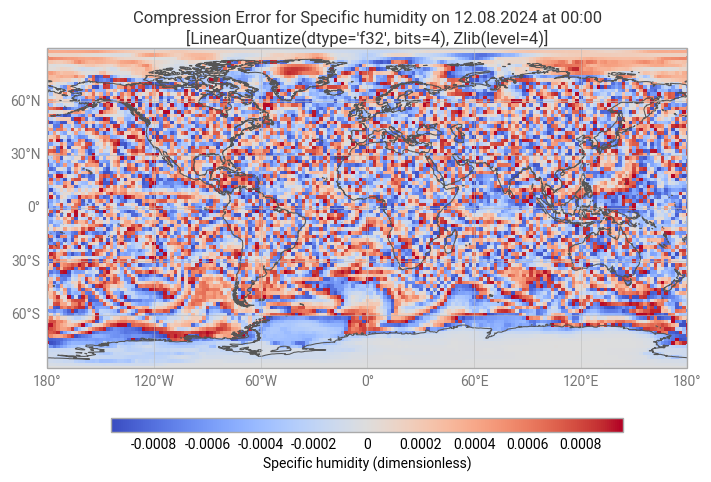

In [17]:
ds_linquant_error = {}
errors_linquant = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_linquant_error[name] = ds_linquant[name] - da
    errors_linquant[name] = compute_relative_errors(ds_linquant[name], da)

plot_data(
    ds_linquant_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{linquant_compressor}", error=True,
)

## Run the BitRound compressor

Bit rounding is a lossy in-place codec that removes false information from the least significant bits of the mantissa of a floating-point number. Measurement and simulation data often produces high precision numbers even though most of the trailing digits are made up of noise and uncertainty. The compression of such data can be aided by setting these bits to a constant value, which a downstream general-purpose compressor can then take advantage of. For bit rounding, the exessive bits are removed by rounding, though other approaches such as zeroing (bit shaving) or alternating between zeroing and setting to all-ones (bit grooming) exist as well.

The BitRound compressor is configured by the number of bits in the mantissa to keep, `keepbits`.

You can find out more about bit rounding, shaving, and grooming in the following publications:

> Caron, J. (2014). *Compression by bit shaving*. Available from: <http://www.unidata.ucar.edu/blogs/developer/entry/compression_by_bit_shaving> [Accessed: 02.10.2024].

> Klöwer, M., Razinger, M., Dominguez, J. J., Düben, P. D., & Palmer, T. N. (2021). Compressing atmospheric data into its real information content. *Nature Computational Science*. 1(11). pp. 713-724. Available from: [doi:10.1038/s43588-021-00156-2](https://doi.org/10.1038/s43588-021-00156-2).

> Zender, C. S. (2016). Bit grooming: statistically accurate precision-preserving quantization with compression, evaluated in the netcdf operators (nco,550 v4.4.8+). *Geoscientific Model Development*. 9(9). pp. 3199-3211. Available from: [doi:10.5194/gmd-9-3199-2016](https://doi.org/10.5194/gmd-9-3199-2016).

In [18]:
ds_bitround = {}
stats_bitround = {}

bitround_compressor = [
    fcbench.codecs.BitRound(keepbits=6),
    fcbench.codecs.Zlib(level=9),
]

for name, da in ds.items():
    ds_bitround[name], stats_bitround[name] = (
        fcbench.compressor.compute_dataarray_compress_decompress(
            da, bitround_compressor,
        )
    )
    print(f"{da.long_name}" + ":")
    display(utils.format_compress_stats(bitround_compressor, stats_bitround[name]))

bitround_compressor = str(bitround_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
BitRound(keepbits=6),1.00,0.09,0.15,0.3,0.1
Zlib(level=9),16.67,0.01,0.08,123.4,3.0


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
BitRound(keepbits=6),1.0,0.13,0.16,0.3,0.1
Zlib(level=9),3.5,0.00,0.06,478.1,8.1


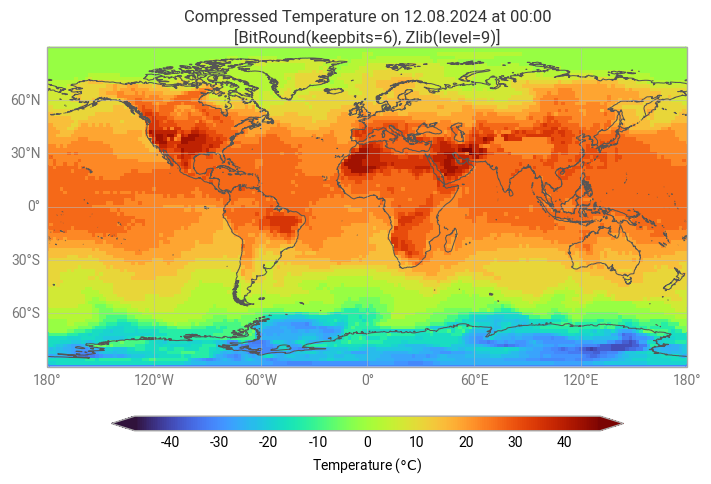

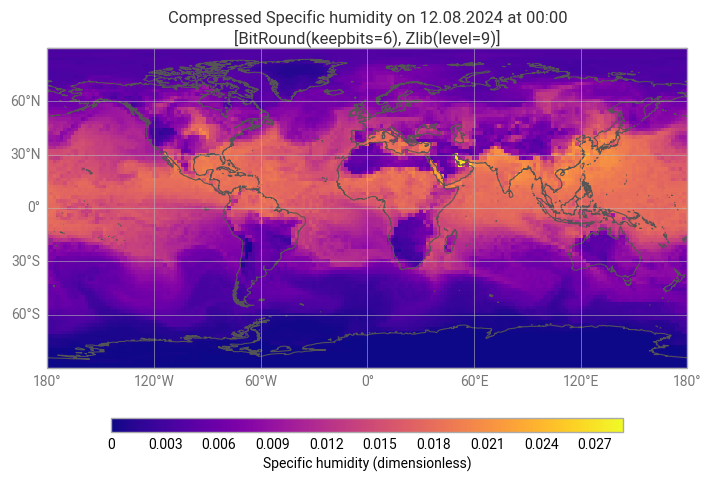

In [19]:
plot_data(
    ds_bitround, title_prefix="Compressed ",
    title_postfix=f"\n{bitround_compressor}",
)

## Plot the BitRound compression error

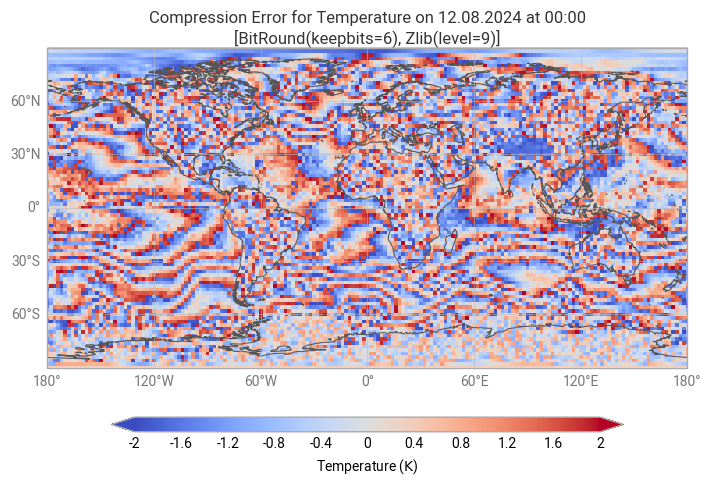

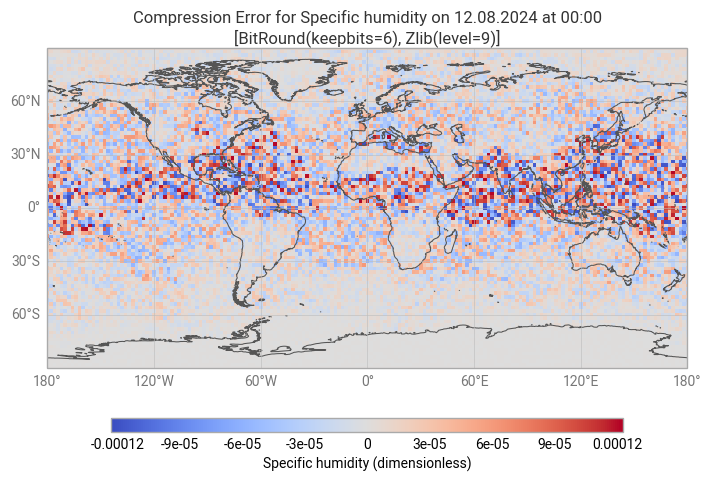

In [20]:
ds_bitround_error = {}
errors_bitround = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_bitround_error[name] = ds_bitround[name] - da
    errors_bitround[name] = compute_relative_errors(ds_bitround[name], da)

plot_data(
    ds_bitround_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{bitround_compressor}", error=True,
)

## Run the transform-based ZFP compressor

ZFP is a lossy transform-based compressor that compresses multidimensional data in $4^d$ chunks where $d$ is the dimensionality of the data. All values in the chunk are decorrelated and then transformed into a binary plane embedding that is roughly ordered by importance. The resulting per-chunk bitstream can be truncated to satisfy a user-provided compression target, e.g. a fixed number of bits, a bitplane precision, or an absolute error tolerance.

You can find out more about the ZFP compressor in its [documentation](https://zfp.readthedocs.io/en/latest/index.html) and the following two publications:

> Diffenderfer, J. et *al*. (2019). Error Analysis of ZFP Compression for Floating-Point Data. *SIAM Journal on Scientific Computing*. 41(3). pp. A1867-A1898. Available from: [doi:10.1137/18M1168832](https://doi.org/10.1137/18M1168832).

> Lindstrom, P. (2014). Fixed-Rate Compressed Floating-Point Arrays. *IEEE Transactions on Visualization and Computer Graphics*. 20(2). pp. 2674-2683. Available from: [doi:10.1109/TVCG.2014.2346458](https://doi.org/10.1109/TVCG.2014.2346458).

In [21]:
ds_zfp = {}
stats_zfp = {}

zfp_compressor = [
    fcbench.codecs.Asinh(linear_width=1.0),
    fcbench.codecs.Zfp(mode="fixed-accuracy", tolerance=1e-3),
]

for name, da in ds.items():
    ds_zfp[name], stats_zfp[name] = (
        fcbench.compressor.compute_dataarray_compress_decompress(
            da, zfp_compressor,
        )
    )
    print(f"{da.long_name}" + ":")
    display(
        utils.format_compress_stats(zfp_compressor, stats_zfp[name])
    )

zfp_compressor = str(zfp_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
Asinh(linear_width=1.0),1.00,0.05,0.06,6.0,9.0
"Zfp(mode='fixed-accuracy', tolerance=0.001)",1.17,0.02,0.03,24.4,18.2


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
Asinh(linear_width=1.0),1.00,0.06,0.08,6.0,7.0
"Zfp(mode='fixed-accuracy', tolerance=0.001)",2.02,0.03,0.04,17.2,12.9


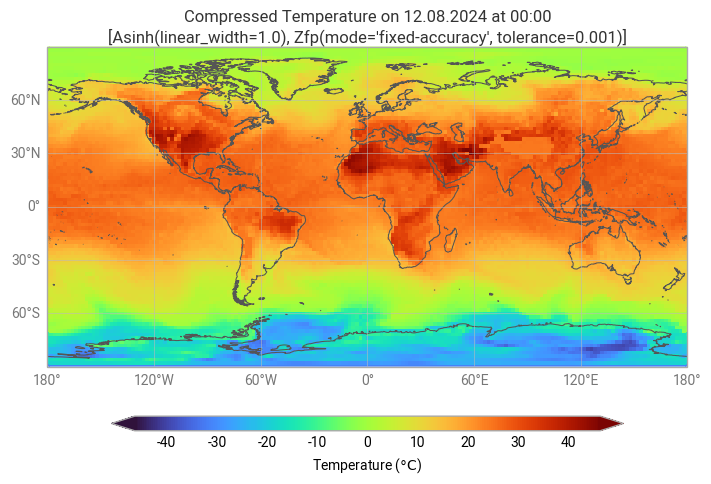

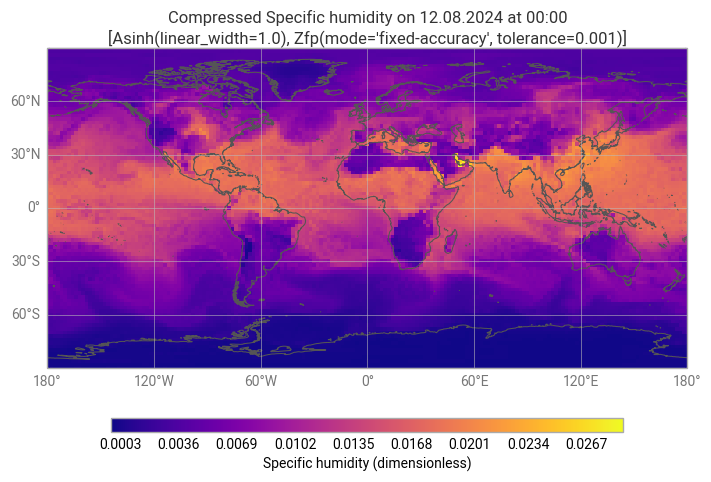

In [22]:
plot_data(
    ds_zfp, title_prefix="Compressed ",
    title_postfix=f"\n{zfp_compressor}",
)

## Plot the ZFP compression error

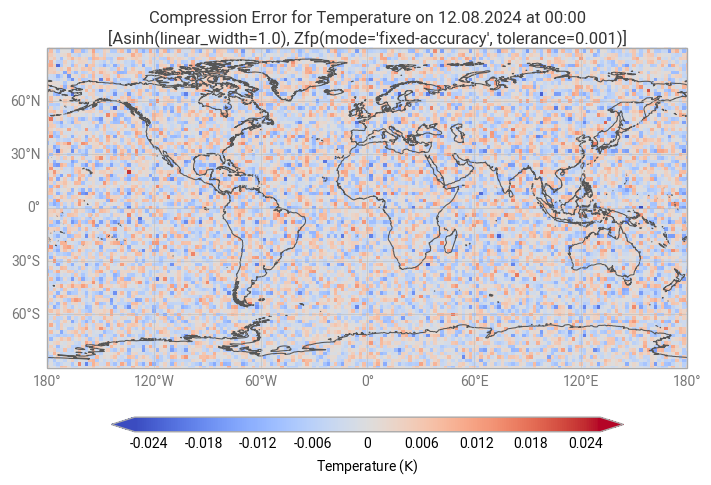

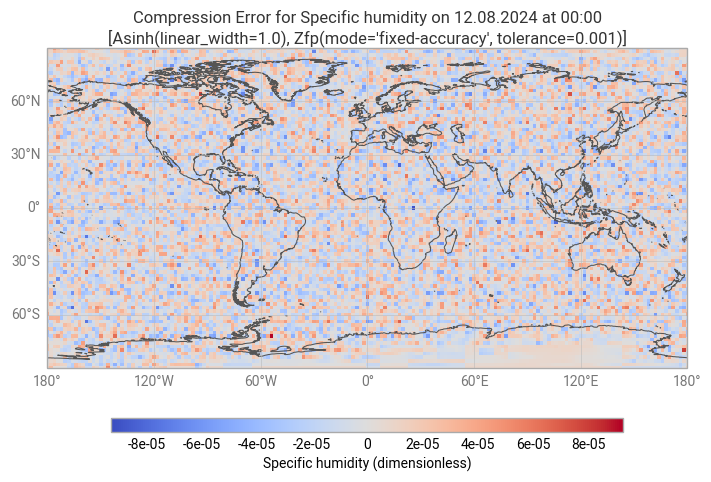

In [23]:
ds_zfp_error = {}
errors_zfp = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_zfp_error[name] = ds_zfp[name] - da
    errors_zfp[name] = compute_relative_errors(ds_zfp[name], da)

plot_data(
    ds_zfp_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{zfp_compressor}", error=True,
)

## Run the prediction-based SZ3 compressor

SZ3 is a lossy prediction-based compressor that compresses multidimensional data by predicting the next value based on an indentified pattern. The quantized prediction errors are stored alongside the pattern. SZ3 is a modular compression pipeline that combines a data preprocessor, predictor, quantizer, encoder, and lossless compressor. The compression error can be bounded with absolute, relative, and PWR error bounds.

You can find out more about the SZ3 compressor in the following publications:

> Liang, X. et *al*. (2023). SZ3: A modular framework for composing prediction-based error-bounded lossy compressors. *IEEE Transactions on Big Data*. 9(2). pp. 485-498. Available from: [doi:10.1109/TBDATA.2022.3201176](https://doi.org/10.1109/TBDATA.2022.3201176).

> Zhao, K. et *al*. (2021). Optimizing Error-Bounded Lossy Compression for Scientiﬁc Data by Dynamic Spline Interpolation. In: *Proceeding of the 37th IEEE International Conference on Data Engineering*. pp. 1643-1654. Available from: [doi:10.1109/ICDE51399.2021.00145](https://doi.org/10.1109/ICDE51399.2021.00145).

> Liang, X. et *al*. (2018). Error-Controlled Lossy Compression Optimized for High Compression Ratios of Scientific Datasets. *IEEE International Conference on Big Data*. pp. 438-447. Available from: [doi:10.1109/BigData.2018.8622520](https://doi.org/10.1109/BigData.2018.8622520).

In [24]:
ds_sz3 = {}
stats_sz3 = {}

sz3_compressor = [fcbench.codecs.Sz3(eb_mode="rel", eb_rel=1e-3)]

for name, da in ds.items():
    ds_sz3[name], stats_sz3[name] = (
        fcbench.compressor.compute_dataarray_compress_decompress(
            da, sz3_compressor,
        )
    )
    print(f"{da.long_name}" + ":")
    display(utils.format_compress_stats(sz3_compressor, stats_sz3[name]))

sz3_compressor = str(sz3_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"Sz3(eb_mode='rel', eb_rel=0.001)",5.45,0.02,0.05,15.8,5.2


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"Sz3(eb_mode='rel', eb_rel=0.001)",4.69,0.03,0.06,16.0,5.6


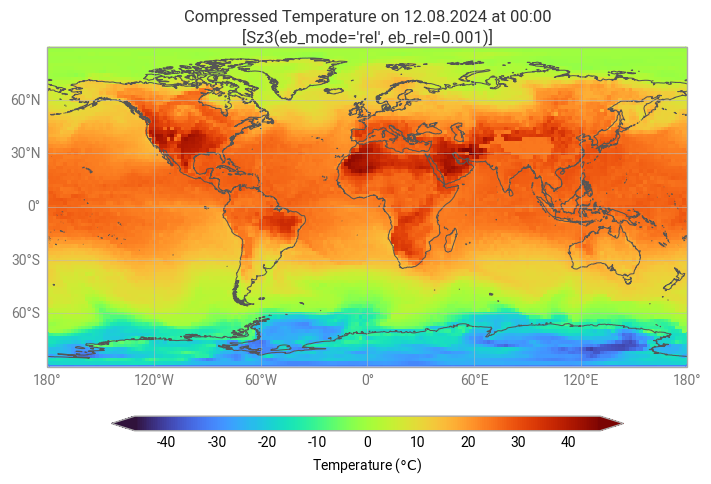

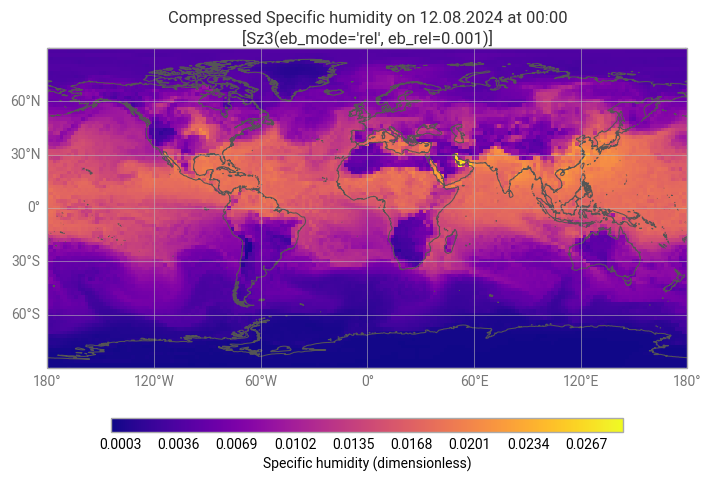

In [25]:
plot_data(
    ds_sz3, title_prefix="Compressed ",
    title_postfix=f"\n{sz3_compressor}",
)

## Plot the SZ3 compression error

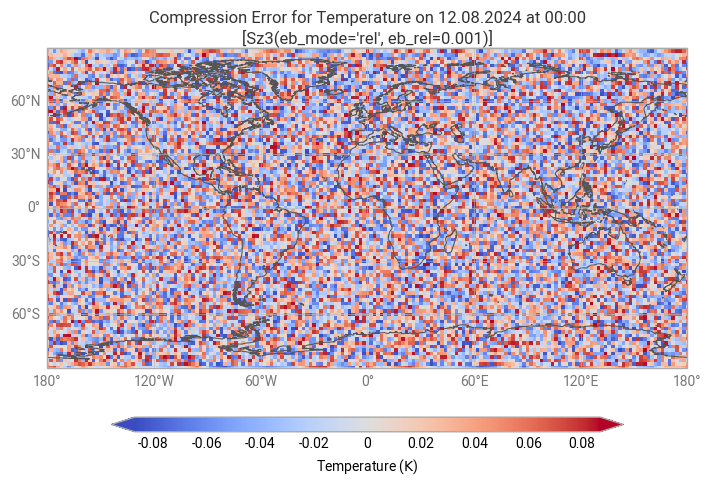

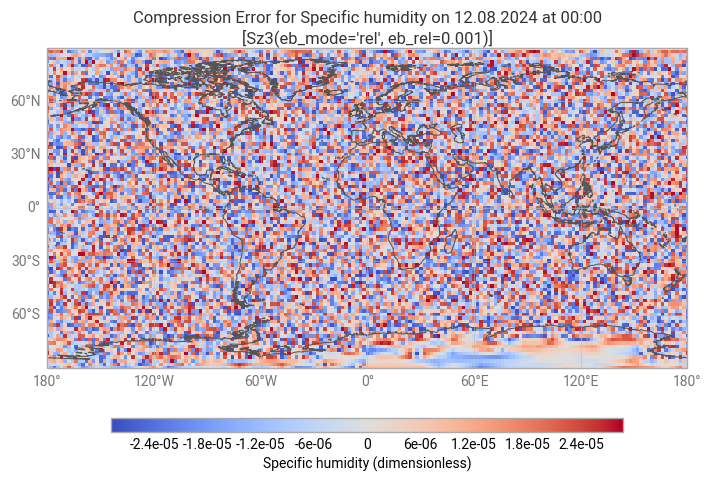

In [26]:
ds_sz3_error = {}
errors_sz3 = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_sz3_error[name] = ds_sz3[name] - da
    errors_sz3[name] = compute_relative_errors(ds_sz3[name], da)

plot_data(
    ds_sz3_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{sz3_compressor}", error=True,
)

## Overview 

Here you get an overview table showing the used compressors, compression factors and resulting $L^1$, $L^2$ and $L^\infty$ errors.

In [27]:
data = []

compressors = {
    linquant_compressor: (errors_linquant, stats_linquant),
    bitround_compressor: (errors_bitround, stats_bitround),
    zfp_compressor: (errors_zfp, stats_zfp),
    sz3_compressor: (errors_sz3, stats_sz3),
}

for compressor_name, (errors, stats) in compressors.items():
    for variable, error_data in errors.items():
        row = {
            "Compressor": compressor_name,
            "Variable": variable,
            "Compression Ratio [raw B / enc B]": round(
                stats[variable][0].decoded_bytes / stats[variable][-1].encoded_bytes,
                2,
            ),
            "L1 Error": error_data.get("Relative_Error_L1", None),
            "L2 Error": error_data.get("Relative_Error_L2", None),
            "Linf Error": error_data.get("Relative_Error_Linf", None),
            "Encode Instructions [# / raw B]": round(
                sum(s.encode_instructions for s in stats[variable])
                / stats[variable][0].decoded_bytes,
                1,
            ),
            "Decode Instructions [# / raw B]": round(
                sum(s.decode_instructions for s in stats[variable])
                / stats[variable][0].decoded_bytes,
                1,
            ),
            "Encode Throughput [raw GB / s]": round(
                1e-9
                * stats[variable][0].decoded_bytes
                / sum(
                    s.encode_timing.secs + s.encode_timing.nanos * 1e-9
                    for s in stats[variable]
                ),
                2,
            ),
            "Decode Throughput [raw GB / s]": round(
                1e-9
                * stats[variable][0].decoded_bytes
                / sum(
                    s.decode_timing.secs + s.decode_timing.nanos * 1e-9
                    for s in stats[variable]
                ),
                2,
            ),
        }
        data.append(row)


df = pd.DataFrame(data).set_index(["Compressor", "Variable"])
df

Compression Ratio [raw B / enc B]  \
Compressor                                         Variable                                      
[LinearQuantize(dtype='f32', bits=4), Zlib(leve... t                                     25.75   
                                                   q                                     20.18   
[BitRound(keepbits=6), Zlib(level=9)]              t                                     16.67   
                                                   q                                      3.50   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t                                      1.17   
                                                   q                                      2.02   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t                                      5.45   
                                                   q                                      4.69   

                                                             L1 Error  \
Compressor                                         Variable             
[LinearQuantize(dtype='f32', bits=4), Zlib(leve... t         0.005129   
                                                   q         0.052013   
[BitRound(keepbits=6), Zlib(level=9)]              t         0.003308   
                                                   q         0.002944   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t         0.000017   
                                                   q         0.001959   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t         0.000146   
                                                   q         0.001642   

                                                             L2 Error  \
Compressor                                         Variable             
[LinearQuantize(dtype='f32', bits=4), Zlib(leve... t         0.005923   
                                                   q         0.050810   
[BitRound(keepbits=6), Zlib(level=9)]              t         0.003879   
                                                   q         0.003563   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t         0.000021   
                                                   q         0.002007   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t         0.000170   
                                                   q         0.001558   

                                                             Linf Error  \
Compressor                                         Variable               
[LinearQuantize(dtype='f32', bits=4), Zlib(leve... t           0.009015   
                                                   q           0.033329   
[BitRound(keepbits=6), Zlib(level=9)]              t           0.006264   
                                                   q           0.004255   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t           0.000080   
                                                   q           0.003220   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t           0.000270   
                                                   q           0.001000   

                                                             Encode Instructions [# / raw B]  \
Compressor                                         Variable                                    
[LinearQuantize(dtype='f32', bits=4), Zlib(leve... t                                    15.2   
                                                   q                                    16.2   
[BitRound(keepbits=6), Zlib(level=9)]              t                                   123.7   
                                                   q                                   478.3   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t                                    30.4   
                                                   q                                    23.2   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t                                    15.8   
   